In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0


In [2]:
!python3 --version

Python 3.10.12


In [3]:
!nvidia-smi

Wed Sep  4 20:32:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060        Off |   00000000:01:00.0  On |                  N/A |
| N/A   45C    P8              6W /   78W |      56MiB /   6144MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Api

In [4]:
import time
import numpy as np
import os
import _pickle as cPickle
import numpy as np
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name as IMAGENET_CLASS_NAMES
import pycuda.autoinit
import pycuda.driver as drv
import numpy
from PIL import Image
import imagehash

from pycuda.compiler import SourceModule

PATH = "../data/cifar-10-batches-py/"
IMAGENET_PATH = "../data/Imagenet32_train/"

In [5]:
def unpickleImages(pairs):
    images = set()
    for elem in pairs:
        images.add(elem[0])
        images.add(elem[1])

    return list(images)

def load_batch(batchFile):
    f = open(PATH+batchFile, 'rb')
    
    dict_ = cPickle.load(f, encoding='latin1')
    images = dict_['data']
    labels = dict_['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

In [6]:
unpickleImages([(1,2, 0.85),(3,4,0.34)])

[1, 2, 3, 4]

In [7]:
CIFAR_IMAGES, CIFAR_LABELS = load_batch("data_batch_1")
CIFAR_CLASS_NAMES = load_classes()
CIFAR_IMAGES.shape

(10000, 3072)

In [8]:
mod = SourceModule("""

#include <cmath>

__global__ void ResizeAndGray1000ImagesInterpotedHash(float* image, float* hash, const int pixels, const int new_rows, 
                                        const int new_cols, const int amountOfImages, const int hashSize)
{

    int idx           = threadIdx.x + blockIdx.x * blockDim.x;
    float* pixelsValues = new float [new_rows * new_cols];

    const float originImageSize = 32;
    float xRatio = originImageSize / new_cols;
    float yRatio = originImageSize / new_rows;

    if ( xRatio < yRatio ) xRatio = yRatio;
    
    if (idx > amountOfImages) return;

    int imageStartIdx = pixels * pixels * 3 * idx;
    
    for( int i=0; i<new_rows; i++ )
    {
        for ( int j=0; j<new_cols; j++)
        {
            float xPixel = i*yRatio;
            float yPixel = j*xRatio;

            const int x_l = floor(xPixel);  // x lower
            const int y_l = floor(yPixel);
            const int x_h = ceil(xPixel);   // x higher
            const int y_h = ceil(yPixel);

            const float x_weight = xPixel - x_l;
            const float y_weight = yPixel - y_l;

            const int pixelToTakeA = imageStartIdx + x_l * 32 + y_l;
            const int pixelToTakeB = imageStartIdx + x_h * 32 + y_l;
            const int pixelToTakeC = imageStartIdx + x_l * 32 + y_h;
            const int pixelToTakeD = imageStartIdx + x_h * 32 + y_h;
            
            const float a = 0.2989 * image[pixelToTakeA] + 0.5870 * image[1024+pixelToTakeA] + 0.1140 * image[2048+pixelToTakeA];
            const float b = 0.2989 * image[pixelToTakeB] + 0.5870 * image[1024+pixelToTakeB] + 0.1140 * image[2048+pixelToTakeB];
            const float c = 0.2989 * image[pixelToTakeC] + 0.5870 * image[1024+pixelToTakeC] + 0.1140 * image[2048+pixelToTakeC];
            const float d = 0.2989 * image[pixelToTakeD] + 0.5870 * image[1024+pixelToTakeD] + 0.1140 * image[2048+pixelToTakeD];

            const float pixel = a * (1 - x_weight) * (1 - y_weight) 
              + b * x_weight * (1 - y_weight) +
              c * y_weight * (1 - x_weight) +
              d * x_weight * y_weight;
              
            pixelsValues[i * new_rows + j ] = pixel;
        }
    }

    for( int i=0; i<new_rows; i++ )
    {
        for ( int j=1; j<new_cols; j++)
        {
            pixelsValues[i*new_rows+j-1] < pixelsValues[i*new_rows+j] ? 
                hash[hashSize*idx+i*new_rows+j-1] = 1 : hash[hashSize*idx+i*new_rows+j-1] = 0;
        }
    }

    delete pixelsValues;

    __syncthreads();
}

""")

ResizeAndGray1000ImagesInterpotedHash = mod.get_function("ResizeAndGray1000ImagesInterpotedHash")

In [9]:
mod = SourceModule("""

__global__ void ComparePairs(float* pairs, float* signatures, float* res, float threshold, float hash_size, int pairsElements)
{
    unsigned int x = blockIdx.x * blockDim.x + threadIdx.x;

    if(x > pairsElements) return;

    const int bitsNumbers = hash_size * hash_size / 8;
    const int imageIdx1 = pairs[x*2];
    const int imageIdx2 = pairs[x*2+1];
    unsigned int hammingDistance = 0;
    
    for(int i=0; i<bitsNumbers; i++)
    {
        unsigned int common = (unsigned int)signatures[imageIdx1*bitsNumbers+i] ^ (unsigned int)signatures[imageIdx2*bitsNumbers+i];

         while ( common>0 )
         {
            unsigned int val = common&1;
            common>>=1;
            hammingDistance += val;
        }
    }

    float similarity = (hash_size * hash_size - hammingDistance) / ( hash_size * hash_size );

    if ( similarity >= threshold )
    {
        res[x] = similarity;
    }
}

""")

ComparePairs = mod.get_function("ComparePairs")

In [10]:
from typing import List, Dict, Tuple

class cuPerceptual:
    def __init__(self, size, hash_size, images):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = numpy.zeros([len(images), hash_size // 8 * hash_size]).astype(numpy.float32)
        self.hash_size = hash_size
        self.images = images;

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)

    def compute_hash(self):
        idx = 0
        for i in range(0, 10):
            signature_1000 = numpy.zeros([1000 * self.hash_size**2 ]).astype(numpy.float32)
            INPUT_IMAGES = self.images[1000*i:1000*i+1000].astype(numpy.float32).reshape(1000 * 1024 * 3)
            ResizeAndGray1000ImagesInterpotedHash(drv.In(INPUT_IMAGES), drv.Out(signature_1000), np.int32(32), 
                        np.int32(self.hash_size), np.int32(self.hash_size+1), np.int32(1000), np.int32(self.hash_size**2),
                        block=(1000,1,1))

            for j in range(0, 1000):
                one_signature = signature_1000[self.hash_size**2 * j: self.hash_size**2 * j+ self.hash_size**2]
                self.signatures[idx] = np.packbits(one_signature.astype(np.int8)).astype(np.float32)
                self.fill_buckets(one_signature, idx)
                idx += 1
    
    def compute_candidate(self):
        candidate_pairs = []

        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket)
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.append(hash_bucket[i])
                            candidate_pairs.append(hash_bucket[j])
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        pairsNumpy = numpy.asarray(candidate_pairs, dtype=np.float32)
        signaturesReshaped = self.signatures.reshape(-1)

        near_duplicates = list()
        
        for i in range(0, pairsNumpy.shape[0], 1000000):
            resSimilarity = numpy.zeros([500000]).astype(numpy.float32)
            ComparePairs(drv.In(pairsNumpy), drv.In(signaturesReshaped), drv.Out(resSimilarity), 
                         np.float32(threshold), np.float32(self.hash_size), np.int32(pairsNumpy.shape[0]//2),
                         block=(1000,1,1), grid=(500,1,1))

            for j in range (0, 1000000, 2):
                if i+j >= pairsNumpy.shape[0]:
                    break;
                if resSimilarity[j//2] > 0:
                    near_duplicates.append( ( int(pairsNumpy[i+j]), int(pairsNumpy[i + j + 1]), resSimilarity[j//2] ) )

        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [13]:
torch.set_default_device('cuda:0') 

In [14]:
class Net2(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.hash1 = nn.Linear(256, bits)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(bits, 10)

    def forward(self, x):
        x = x.to(torch.float32)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.hash1(x)
        hash_= self.sigmoid(x);
        x = self.fc2(x)
        return x, hash_

HASH_SIZE = 64
net2 = Net2( HASH_SIZE )
net2.to("cuda:0")

Net2(
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (hash1): Linear(in_features=256, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [15]:
from torchvision import models

resnet50 = models.resnet50(pretrained = True) # weights=ResNet50_Weights.DEFAULT
resnet50 = resnet50.to("cuda:0")
resnet50.fc = torch.nn.Identity()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
net2 = Net2( HASH_SIZE ).to("cuda:0")

In [17]:
model2 = nn.Sequential(resnet50, net2)

In [18]:
for param in model2.parameters():
    param.requires_grad = False

In [19]:
PATH = "../2.NeuralHashing/mainModel.pth"
model2.load_state_dict(torch.load(PATH))
model2 = model2.eval()

In [20]:
from typing import List, Dict, Tuple

class cuNN:
    def __init__(self, size, hash_size, images, size_images ):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = numpy.zeros([len(images), hash_size // 8 * hash_size]).astype(numpy.float32)
        self.hash_size = hash_size
        self.images = images;
        self.size_ = size_images

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)

    def compute_hash(self):
        
        tensor_image = torch.FloatTensor(self.images).reshape(self.size_,3,32,32).to("cuda:0")
        label, hash_ = model2(tensor_image)
        signatures = hash_.cpu().detach().numpy().astype(np.int8)

        idx = 0
        for signature in signatures:
            self.signatures[idx] = np.packbits( signature ).astype(np.float32)
            self.fill_buckets(signature, idx)
            idx+=1
        return self.signatures
    
    def compute_candidate(self):
        candidate_pairs = set()

        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket)
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i], hash_bucket[j]])
                            )
        return candidate_pairs
    
    def check_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [114]:
nnLSH = cuNN(8, 8, CIFAR_IMAGES)
signatures = nnLSH.compute_hash()

print(signatures.shape)

pairs = nnLSH.compute_candidate()

print(len(pairs))
#duplicates = nnLSH.check_candidate(pairs)

# get images from duplicates
DUPLICATED_IMAGES = unpickleImages(duplicates)
#DUPLICATED_IMAGES=CIFAR_IMAGES
perceptualLSH = cuPerceptual(8, 8,DUPLICATED_IMAGES)
perceptualLSH.compute_hash()
pairs2 = perceptualLSH.compute_candidate()
duplicates2 = perceptualLSH.check_candidate(pairs2)

#calculate metrics
## size = len(self.images);

TypeError: cuNN.__init__() missing 1 required positional argument: 'size_images'

In [49]:
perceptualLSH = cuPerceptual(8, 8,CIFAR_IMAGES)
perceptualLSH.compute_hash()
pairs3 = perceptualLSH.compute_candidate()
duplicates3 = perceptualLSH.check_candidate(pairs3, 0.9)

# get images from duplicates
DUPLICATED_INDICES2 = unpickleImages(duplicates3)
DUPLICATED_IMAGES2 = np.array(CIFAR_IMAGES)[DUPLICATED_INDICES2]

LogicError: cuFuncSetBlockShape failed: invalid resource handle

In [50]:
# Treshold wwazny zeby odfiltrowac nie duplikaty
# Porownywanie duplikatow zdjec - przy podwojnym filtrowaniu ???
# 6 milionow par potencjalych przy sieci neuronowej
# Pierw musi chodzic PyCUDA poniej doperio cos PyTorch, zeby nie bylo przeklama w dostepie do cuda

In [51]:
print(len(DUPLICATED_IMAGES2))
print(CIFAR_IMAGES.shape)

nnLSH = cuNN(8, 8,DUPLICATED_IMAGES2, len(DUPLICATED_IMAGES2))
signatures2 = nnLSH.compute_hash()
print(signatures2.shape)

pairs4 = nnLSH.compute_candidate()
print(len(pairs4))
#print(pairs4[0])
duplicates4 = nnLSH.check_candidate(pairs4)

#calculate metrics

88
(10000, 3072)
(88, 8)
3827


In [22]:
duplicates4

[(5, 83, 1.0),
 (40, 77, 1.0),
 (41, 42, 1.0),
 (39, 81, 1.0),
 (14, 24, 1.0),
 (66, 71, 1.0),
 (73, 87, 1.0),
 (24, 87, 1.0),
 (50, 81, 1.0),
 (3, 5, 1.0),
 (5, 50, 1.0),
 (6, 51, 1.0),
 (30, 79, 1.0),
 (73, 77, 1.0),
 (31, 80, 1.0),
 (23, 76, 1.0),
 (43, 54, 1.0),
 (5, 27, 1.0),
 (65, 78, 1.0),
 (16, 73, 1.0),
 (69, 84, 1.0),
 (31, 57, 1.0),
 (46, 78, 1.0),
 (31, 34, 1.0),
 (31, 70, 1.0),
 (43, 44, 1.0),
 (34, 81, 1.0),
 (7, 63, 1.0),
 (26, 76, 1.0),
 (23, 43, 1.0),
 (37, 63, 1.0),
 (16, 40, 1.0),
 (3, 70, 1.0),
 (38, 64, 1.0),
 (49, 73, 1.0),
 (27, 54, 1.0),
 (0, 73, 1.0),
 (33, 70, 1.0),
 (52, 83, 1.0),
 (3, 83, 1.0),
 (27, 31, 1.0),
 (23, 33, 1.0),
 (33, 83, 1.0),
 (14, 69, 1.0),
 (26, 43, 1.0),
 (27, 44, 1.0),
 (14, 82, 1.0),
 (0, 40, 1.0),
 (44, 46, 1.0),
 (3, 50, 1.0),
 (26, 33, 1.0),
 (78, 80, 1.0),
 (70, 76, 1.0),
 (33, 50, 1.0),
 (3, 27, 1.0),
 (16, 82, 1.0),
 (26, 46, 1.0),
 (43, 76, 1.0),
 (14, 49, 1.0),
 (39, 83, 1.0),
 (10, 56, 1.0),
 (22, 30, 1.0),
 (77, 87, 1.0),
 (40,

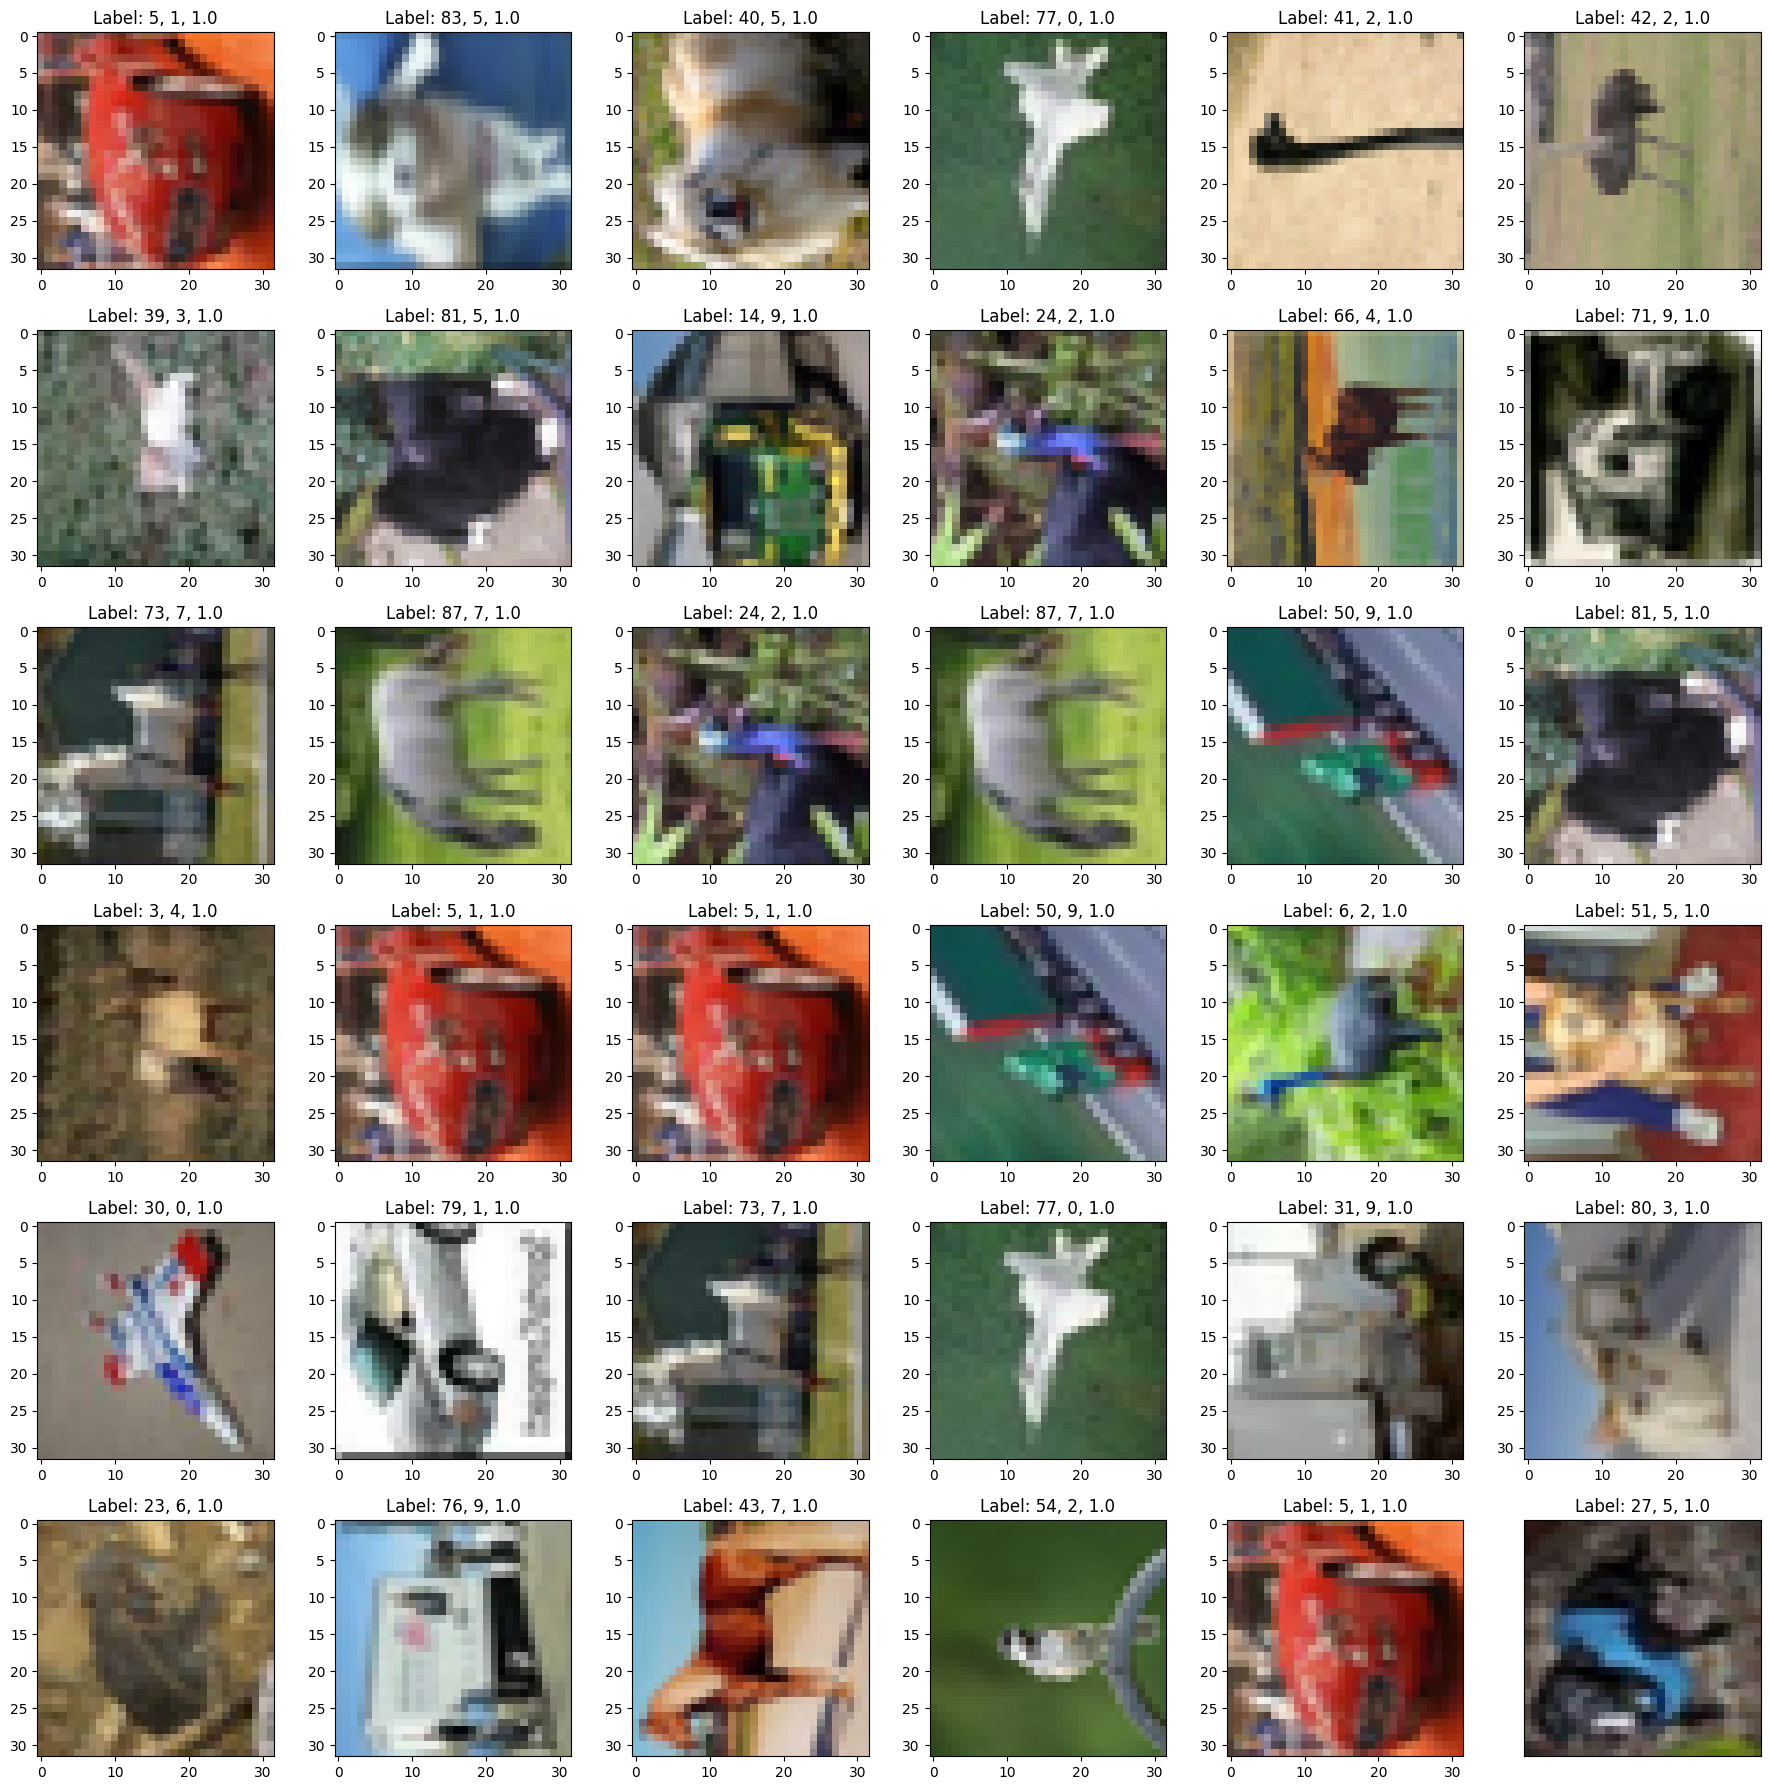

In [48]:
from matplotlib import pyplot as plt

num_row = 6
num_col = 6
col_idx = 0
row_idx = 0

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col//2, 1):
    if col_idx >= num_col -1:
        col_idx = 0
        row_idx += 1
    
    ax = axes[row_idx, col_idx]
    ax.imshow(CIFAR_IMAGES[duplicates4[i + idx_start ][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates4[i + idx_start ][0]}, {CIFAR_LABELS[duplicates4[i + idx_start ][0]]}, {duplicates4[i + idx_start][2]}""")

    col_idx += 1
    ax = axes[row_idx, col_idx]
    ax.imshow(CIFAR_IMAGES[duplicates4[i + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates4[i + idx_start][1]}, {CIFAR_LABELS[duplicates4[i + idx_start][1]]}, {duplicates4[i + idx_start][2]}""")
    col_idx += 1

plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()